# Notes
Once the mounting above is complete, I'm thinking we manage our directory like:
- `models/` - maybe we can just store our models here?
- `results/` - any output statistics/graphs to visualize our results
- `utils/` - assuming we'll have at least some utility helper functions/classes

# Step 0a. Initial Setup

In [1]:
# set up path to the dataset - to get us all to the same point, I just added
# a shortcut to "cs7643_project_code" at my "My Drive" level
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/MyDrive/cs7643_project_code/

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1xCULGSNhEUf0PVtHkYfrHc7YO1WGpj7L/cs7643_project_code


In [2]:
# pip installs
!pip install -q fiftyone

# Step 0b. Dependencies/Imports

In [3]:
import fiftyone as fo
import fiftyone.zoo as foz
import matplotlib.pyplot as plt
from networks.FasterRCNN import FasterRCNN
from utils import AnchorBoxUtil, DataManager, ImageUtil, TrainingUtil
import torch
import torch.nn as nn
import torchvision

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device is: {}'.format(device))

Current device is: cuda


# Step 0c. Data Preparation

In [5]:
# data parameters
dataset_name = "voc-2007"
num_train = 20
num_val = 5
h_img_std = 480 # standard image height to resize to
w_img_std = 640 # standard image width to resize to

# initial import from fiftyone.zoo
dataset_train = foz.load_zoo_dataset(
    dataset_name,
    splits=["train"],
    max_samples=num_train
)
dataset_val = foz.load_zoo_dataset(
    dataset_name,
    splits=["validation"],
    max_samples=num_val
)

# load images into tensors and parse out the target information (bounding boxes and labels)
data_train, data_val, cat_ids = DataManager.load_data(dataset_train, dataset_val, (h_img_std, w_img_std))

Split 'train' already downloaded


INFO:fiftyone.zoo.datasets:Split 'train' already downloaded


Loading 'voc-2007' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'voc-2007' split 'train'


 100% |███████████████████| 20/20 [88.8ms elapsed, 0s remaining, 225.3 samples/s]     


INFO:eta.core.utils: 100% |███████████████████| 20/20 [88.8ms elapsed, 0s remaining, 225.3 samples/s]     


Dataset 'voc-2007-train-20' created


INFO:fiftyone.zoo.datasets:Dataset 'voc-2007-train-20' created


Split 'validation' already downloaded


INFO:fiftyone.zoo.datasets:Split 'validation' already downloaded


Loading 'voc-2007' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'voc-2007' split 'validation'


 100% |█████████████████████| 5/5 [42.2ms elapsed, 0s remaining, 118.6 samples/s]    


INFO:eta.core.utils: 100% |█████████████████████| 5/5 [42.2ms elapsed, 0s remaining, 118.6 samples/s]    


Dataset 'voc-2007-validation-5' created


INFO:fiftyone.zoo.datasets:Dataset 'voc-2007-validation-5' created
Pre-processing [Validation] Dataset: 100%|██████████| 5/5 [00:00<00:00, 38.62it/s]


# Step 0d. Examples

## Example Using ImageUtil

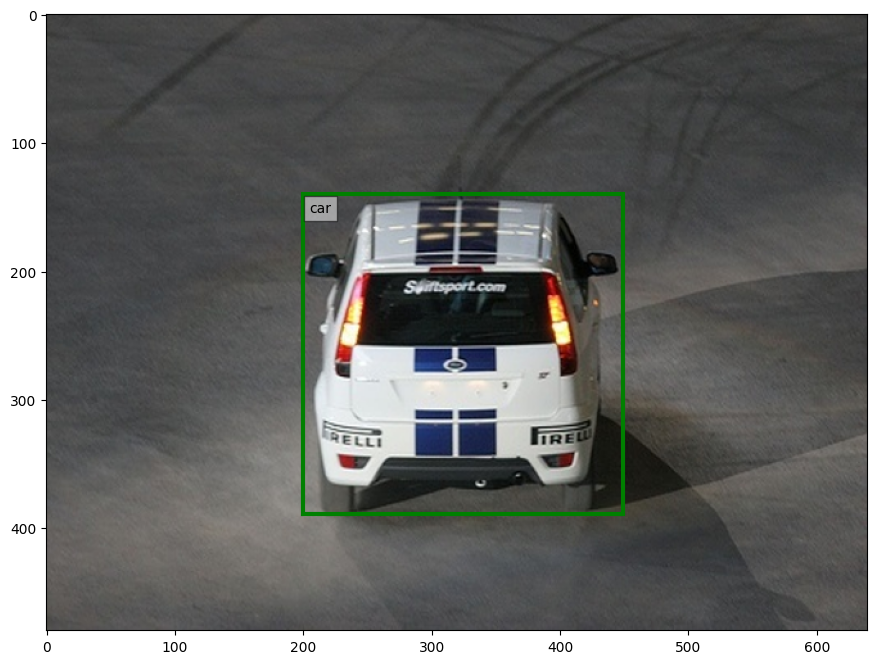

In [6]:
# data visualization tool
# session = fo.launch_app(dataset_train)

# example for using ImageUtil
example_idx = 0
id_cats = {cat_ids[key]: key for key in cat_ids.keys()}                            # reverse the category ids
example_image = data_train.images[example_idx].long()                              # look up the image and convert to long
example_labels = [id_cats[key] for key in data_train.labels[example_idx].tolist()] # get the actual label string(s)
example_bboxes = data_train.bboxes[example_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, example_bboxes, example_labels, 'g')

## Generating Positive/Negative Anchors

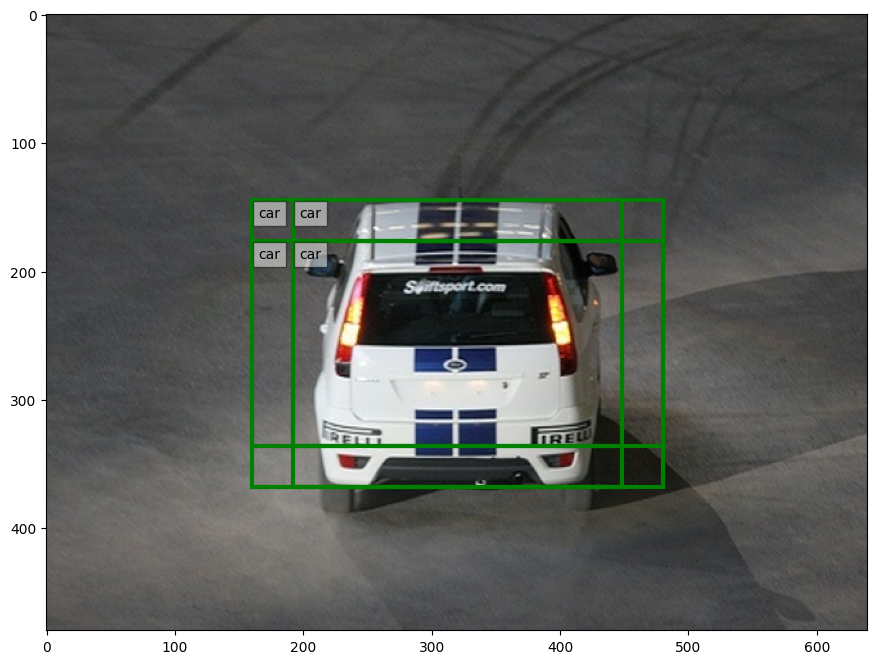

In [7]:
# generate anchor boxes
scales = [2, 4, 6]
ratios = [0.5, 1, 1.5]
anchor_bboxes = AnchorBoxUtil.generate_anchor_boxes(15, 20, scales, ratios)
all_anchor_bboxes = anchor_bboxes.repeat(data_train.n_samples, 1, 1, 1, 1)
train_bboxes = AnchorBoxUtil.scale_bboxes(data_train.bboxes, 1 / 32, 1 / 32)

# evaluate for positive and negative anchors
pos_thresh = 0.68
neg_thresh = 0.3
pos_inds_flat, neg_inds_flat, pos_scores, pos_offsets, pos_labels, pos_bboxes, pos_points, neg_points, pos_inds_batch = AnchorBoxUtil.evaluate_anchor_bboxes(all_anchor_bboxes, train_bboxes, data_train.labels, pos_thresh, neg_thresh)

top_n = 10
pos_classes = pos_labels[pos_inds_batch == example_idx][:top_n]
pos_bboxes = pos_points[pos_inds_batch == example_idx][:top_n]

# display positives
lab = [id_cats[i] for i in pos_classes.tolist()]
pos_bboxes = AnchorBoxUtil.scale_bboxes(pos_bboxes, 32, 32)
ImageUtil.build_image(example_image, pos_bboxes, lab, 'g', show=True)

# Step 1. Faster R-CNN

## Step 1a. Initialize Model

In [8]:
# parameters
img_size = (h_img_std, w_img_std)
roi_size = (3, 3)
n_labels = len(cat_ids) - 1
pos_thresh = 0.6
neg_thresh = 0.30
hidden_dim = 512
dropout = 0.1
backbone_size = (2048, 15, 20)

model = FasterRCNN(img_size, roi_size, n_labels, backbone_size, pos_thresh, neg_thresh, hidden_dim, dropout)

## Step 1b. Training

In [9]:
# parameters
learning_rate = 1e-3
momentum = 0.95
num_epochs = 20
batch_size = 128

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# run training
loss_results = TrainingUtil.train_model(model, optimizer, data_train, num_epochs, batch_size)

Running Epoch: 00 / 20


  0%|          | 0/1 [01:49<?, ?it/s]


KeyboardInterrupt: 

## Step 1c. Evaluation

In [ ]:
model.eval()

## Step 1d. Comparison Against Other Pre-Trained Models

In [ ]:
# # code is adapted from: https://pytorch.org/vision/stable/models.html

# from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

# # initialize weights
# weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# # initialize model
# fpn_model = fasterrcnn_resnet50_fpn(weights=weights)

# # transform the input images
# preprocess = weights.transforms()
# image_set = [preprocess(image) for image in x_train]

# # evaluate the images
# output = fpn_model(image_set)

# # interpret the labels (bounding boxes live in output["boxes"])
# labels = [weights.meta["categories"][i] for i in output["labels"]]

## RPN implementations

In [ ]:
# RPN network
class RPN(nn.Module):
    """
    RPN network, outputs objectiveness scores per pixel, and bbox deltas (t_x, t_y, t_w, t_h) per pixel
    """

    def __init__(self, k, depth):
        super(RPN, self).__init__()

        self.conv = nn.Conv2d(in_channels=depth, out_channels=512, kernel_size=3, padding=1)
        self.conv_class = nn.Conv2d(in_channels=512, out_channels=2 * k, kernel_size=1)
        self.conv_regress = nn.Conv2d(in_channels=512, out_channels=4 * k, kernel_size=1)
        self.ReLU = nn.ReLU()
        self.SM = nn.Softmax(dim=2)

    def forward(self, features):
        batch_size = features.shape[0] # features are in size batch_size x channel_size x H x W
        features = self.ReLU(self.conv(features))

        rpn_objectivity = self.conv_class(features) # batch_size x scores x H x W, H and W are sizes of the feature map, not the original input image
        rpn_objectivity = rpn_objectivity.permute(0, 2, 3, 1)
        rpn_objectivity = rpn_objectivity.reshape(batch_size, -1, 2) # batch_size x (total # of anchors) x (yes/no score for classifying whether there is an object in bb)
        rpn_objectivity = self.SM(rpn_objectivity)
        rpn_objectivity = rpn_objectivity[:, :, 0]

        rpn_delta = self.conv_regress(features) # batch_size x bb_sizes x H x W, H and W are sizes of the feature map, not the original input image
        rpn_delta = rpn_delta.permute(0, 2, 3, 1)
        rpn_delta = rpn_delta.reshape(batch_size, -1, 4) # batch_size x (total # of anchors) x (4 bb size numbers)

        return rpn_objectivity, rpn_delta

In [ ]:
def gen_k_center_anchors(sizes, aspect_ratios):
    """
    Generates k 0-centered anchors, where k = len(scales) x len(aspect_ratios)
    :param sizes: tuple of scales, defined as sqrt(H x W)
    :param aspect_ratios: tuple of aspect_ratios, defined as W:H
    :return: tensor of anchors, k x 4, in format x1, y1, x2, y2
    """

    sizes = torch.as_tensor(sizes, dtype=torch.float32)
    aspect_ratios = torch.as_tensor(aspect_ratios)
    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1.0 / h_ratios

    h_ratios = h_ratios.unsqueeze(1)
    w_ratios = w_ratios.unsqueeze(1)
    sizes = sizes.unsqueeze(0)

    w = torch.matmul(w_ratios, sizes).reshape(-1)
    h = torch.matmul(h_ratios, sizes).reshape(-1)

    base_anchors = torch.stack([-w, -h, w, h], dim=1) / 2
    return base_anchors.round()


def get_anchors(img, features, k_center_anchors):
    """
    Generates the anchors on a given input image
    :param img: input image
    :param features: feature map corresponding to input image. This is assumed to be the output of the final conv layer
    :return: anchors corresponding to each input image, tensor (k * feature_W * feature_H) x 4
    """

    image_h, image_w = img.shape[-2:]
    feature_h, feature_w = features.shape[-2:]
    image_interval_w = int(image_w / feature_w)
    image_interval_h = int(image_h / feature_h)

    image_centers_w = torch.arange(0, feature_w) * image_interval_w
    image_centers_h = torch.arange(0, feature_h) * image_interval_h

    image_centers_w, image_centers_h = torch.meshgrid(image_centers_w, image_centers_h)

    image_centers_w = image_centers_w.reshape(-1)
    image_centers_h = image_centers_h.reshape(-1)

    image_centers = torch.stack([image_centers_w, image_centers_h, image_centers_w, image_centers_h], dim=1)

    k = k_center_anchors.shape[0]
    num_centers = image_centers.shape[0]

    image_centers = image_centers.repeat_interleave(k, dim=0)
    k_center_anchors = k_center_anchors.repeat(num_centers, 1)

    anchors = image_centers + k_center_anchors

    return anchors


def get_anchors_batch(img_all, sizes, aspect_ratios, feature_extractor):
    """
    Generates a list of anchors corresponding to the list of input images
    :param img_all: a tensor containing a batch of input images: (num images) x 3 x H x W
    :param sizes: tuple of scales, defined as sqrt(H x W)
    :param aspect_ratios: tuple of aspect_ratios, defined as W:H
    :param feature_extractor: the feature extractor object to use to extract features from the last conv layer
    :return: A tensor of anchors along with a tensor of extracted features for use in other networks
    """

    batch_size = img_all.shape[0]
    features_all = feature_extractor(img_all)['feature']
    k_center_anchors = gen_k_center_anchors(sizes, aspect_ratios)
    anchors = get_anchors(img_all[0, :, :, :], features_all[0, :, :, :], k_center_anchors)
    anchors = anchors.unsqueeze(0).repeat(batch_size, 1, 1)

    return anchors, features_all



def delta_to_boxes(rpn_delta, anchors):
    """
    Applies learned deltas from RPN network to the anchors to generate predicted boxes
    :param rpn_delta: learned deltas from RPN network (t_x, t_y, t_w, t_h), dimensions: num_anchors x 4
    :param anchors: anchors on input image (x1, y1, x2, y2)
    :return: predicted boxes
    """
    anchors_xywh = box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh')

    x_a = anchors_xywh[:, 0::4]
    y_a = anchors_xywh[:, 1::4]
    w_a = anchors_xywh[:, 2::4]
    h_a = anchors_xywh[:, 3::4]

    t_x = rpn_delta[:, 0::4]
    t_y = rpn_delta[:, 1::4]
    t_w = rpn_delta[:, 2::4]
    t_h = rpn_delta[:, 3::4]

    t_w = torch.clamp(t_w, max=4)
    t_h = torch.clamp(t_h, max=4)

    pred_box_x = torch.multiply(t_x, w_a) + x_a
    pred_box_y = torch.multiply(t_y, h_a) + y_a
    pred_box_w = torch.multiply(w_a, torch.exp(t_w))
    pred_box_h = torch.multiply(h_a, torch.exp(t_h))

    pred_box = torch.cat((pred_box_x, pred_box_y, pred_box_w, pred_box_h), dim=1)
    pred_box = box_convert(pred_box, in_fmt='cxcywh', out_fmt='xyxy')

    return pred_box


def boxes_to_delta(anchor_coords, pred_coords):
    # calculate offset as detailed in the paper
    anc = box_convert(anchor_coords, in_fmt='xyxy', out_fmt='cxcywh')
    pred = box_convert(pred_coords, in_fmt='xyxy', out_fmt='cxcywh')

    tx = (pred[:, 0] - anc[:, 0]) / anc[:, 2]
    ty = (pred[:, 1] - anc[:, 1]) / anc[:, 3]
    tw = torch.log(pred[:, 2] / anc[:, 2])
    th = torch.log(pred[:, 3] / anc[:, 3])

    return torch.stack([tx, ty, tw, th]).transpose(0, 1)


def evaluate_anchor_bboxes(all_anchor_bboxes, all_truth_bboxes, all_truth_labels, pos_thresh, neg_thresh, output_batch=128, pos_fraction=0.5):
    # batch_size = len(all_anchor_bboxes)
    # num_anchor_bboxes_per = np.prod(list(all_anchor_bboxes.shape)[1:-1])
    # max_objects = all_truth_labels.shape[1]

    num_pos = int(output_batch * pos_fraction)
    num_neg = int(output_batch * (1 - pos_fraction))

    # evaluate IoUs
    pos_coord_inds, neg_coord_inds, pos_scores, pos_classes, pos_offsets = [], [], [], [], []

    for idx, (anchor_bboxes, truth_bboxes, truth_labels) in enumerate(zip(all_anchor_bboxes, all_truth_bboxes, all_truth_labels)):
        # calculate the IoUs
        # anchor_bboxes_flat = anchor_bboxes.reshape(-1, 4)
        iou_set = box_iou(anchor_bboxes, truth_bboxes) # iou matrix, (num anchors) x (gt bboxes)

        # get the max per category
        iou_max_per_label, _ = iou_set.max(dim=0, keepdim=True)
        iou_max_per_bbox, _ = iou_set.max(dim=1, keepdim=True)

        # "positive" consists of any anchor box that is (at least) one of:
        # 1. the max IoU and a ground truth box
        # 2. above our threshold
        pos_mask = torch.logical_and(iou_set == iou_max_per_label, iou_max_per_label > 0)
        pos_mask = torch.logical_or(pos_mask, iou_set > pos_thresh)
        pos_inds_flat = torch.where(pos_mask)[0]

        if len(pos_inds_flat) > num_pos:
            # from pos_inds_flat, randomly sample num_pos samples without replacement
            rand_idx_pos = torch.randperm(len(pos_inds_flat))
            pos_inds_flat = pos_inds_flat[rand_idx_pos][0 : num_pos]
            pos_coord_inds.append(pos_inds_flat)
        else:
            # take all positive samples
            pos_coord_inds.append(pos_inds_flat)

        # "negative" consists of any anchor box whose max is below the threshold
        neg_mask = iou_max_per_bbox < neg_thresh
        neg_inds_flat = torch.where(neg_mask)[0]

        if len(pos_inds_flat) > num_pos:
            # from neg_inds_flat, randomly sample num_neg samples without replacement
            rand_idx_neg = torch.randperm(len(neg_inds_flat))
            neg_inds_flat = neg_inds_flat[rand_idx_neg][0 : num_neg]
            neg_coord_inds.append(neg_inds_flat)
        else:
            # pad with negative samples
            rand_idx_neg = torch.randperm(len(neg_inds_flat))
            neg_inds_flat = neg_inds_flat[rand_idx_neg][0 : (num_neg + num_pos - len(pos_inds_flat))]
            neg_coord_inds.append(neg_inds_flat)

        # get the IoU scores
        pos_scores.append(iou_max_per_bbox[pos_inds_flat])

        # get the classifications
        pos_indices = iou_set.argmax(dim=1)[pos_inds_flat]
        pos_classes_i = truth_labels[pos_indices]
        pos_classes.append(pos_classes_i)

        # calculate the offsets
        pos_offsets.append(boxes_to_delta(anchor_bboxes[pos_inds_flat], truth_bboxes[pos_indices]))

    return pos_coord_inds, neg_coord_inds, pos_scores, pos_classes, pos_offsets

In [ ]:
# initialize ResNet50 model
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# create feature extractor
feature_extractor = create_feature_extractor(resnet, return_nodes={'layer4.2.relu_2': 'feature'})

# define sizes and aspect ratios
sizes = (64, 128, 256)
aspect_ratios = (0.5, 1, 2)
k = len(sizes) * len(aspect_ratios)

# generate anchors, extract features
anchors_all, features_all = get_anchors_batch(data_train.images, sizes, aspect_ratios, feature_extractor)
features_all = features_all.detach()

# define anchor evaluation parameters and evaluate the anchors
pos_thresh = 0.7
neg_thresh = 0.3
anchors_all = clip_boxes_to_image(anchors_all, data_train.images[0].shape[-2:])
pos_coord_inds, neg_coord_inds, pos_scores, pos_classes, pos_offsets = evaluate_anchor_bboxes(anchors_all, data_train.bboxes, data_train.labels, pos_thresh, neg_thresh)

# initialize RPN network
rpn = RPN(k, features_all.shape[1])
rpn.train()

# initialize loss functions and optimizer
cls_loss = torch.nn.BCELoss()
reg_loss = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(rpn.parameters(), lr=0.001)

batch_size = len(pos_coord_inds)
epoch = 20
lmb = 20

# training loop, needs cleaning up
for i in range(epoch):
    for j in range(batch_size):
        rpn_objectivity_all, rpn_delta_all = rpn(features_all[j, :, :, :].unsqueeze(0))
        rpn_objectivity = rpn_objectivity_all.squeeze()
        rpn_delta = rpn_delta_all.squeeze()
        pos_coord_ind = pos_coord_inds[j]
        neg_coord_ind = neg_coord_inds[j]
        gt_labels = torch.zeros((128,))
        gt_labels[0 : len(pos_coord_ind)] = 1
        pos_offset = pos_offsets[j]
        rpn_objectivity_possel = rpn_objectivity[pos_coord_ind]
        rpn_objectivity_negsel = rpn_objectivity[neg_coord_ind]
        rpn_objectivity_sel = torch.cat([rpn_objectivity_possel, rpn_objectivity_negsel], dim=0)
        rpn_delta_possel = rpn_delta[pos_coord_ind, :]
        loss = cls_loss(rpn_objectivity_sel, gt_labels) + lmb * reg_loss(rpn_delta_possel, pos_offset)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        print(loss)